## Load data

### Imports

In [2]:
import pickle
import random
import os
import json
import csv
import re
import numpy as np
import pandas as pd
from scipy.sparse import *
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold

import os
import sys

current_path = os.getcwd()
parent_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(parent_path)

### Downloads

In [2]:
# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/hanygeor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hanygeor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hanygeor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Create df with raw data

In [4]:
with open(os.path.join(parent_path,'data/train_neg_full.txt'), 'r') as file:
    neg_lines = file.readlines()

with open(os.path.join(parent_path,'data/train_pos_full.txt'), 'r') as file:
    pos_lines = file.readlines()

df_neg = pd.DataFrame({'Text': neg_lines})
df_neg["Label"] = -1
df_pos = pd.DataFrame({'Text': pos_lines})
df_pos["Label"] = 1

df_raw = pd.concat([df_neg, df_pos])
df_raw = df_raw.reset_index(drop=True)

## Preprocessing

### Lemmatization

Build df with no lemmatization

In [4]:
# Drop dulicates from raw df to obtain the no lemmatization df
df_no_lem = df_raw.copy()
df_no_lem.drop_duplicates(inplace=True)
df_no_lem.reset_index(drop=True, inplace=True)

Build df with partial lemmatization

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

df_half_lem = df_no_lem.copy()

# Function to convert NLTK's POS tags to the format required by WordNetLemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function to lemmatize a sentence with appropriate POS tags
def lemmatize_sentence_with_pos(sentence):
    words = sentence.split()  # Tokenize by splitting on whitespace
    words_with_pos = pos_tag(words)
    
    # Lemmatize only if word is noun or verb
    lemmatized_words = []
    for word, pos in words_with_pos:
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos in [wordnet.NOUN, wordnet.VERB]:
            lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
        else:
            lemmatized_word = word  # Keep word as is if not noun/verb
        lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

# Apply the lemmatization with POS tagging to each sentence in the DataFrame
df_half_lem['Text'] = df_half_lem['Text'].apply(lemmatize_sentence_with_pos)

Build df with complete lemmatization

In [6]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

df_full_lem = df_no_lem.copy()

# Function to convert NLTK's POS tags to the format required by WordNetLemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function to lemmatize a sentence with appropriate POS tags
def lemmatize_sentence_with_pos(sentence):
    words = sentence.split()  # Tokenize by splitting on whitespace
    words_with_pos = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in words_with_pos]
    return ' '.join(lemmatized_words)

# Apply the lemmatization with POS tagging to each sentence in the DataFrame
df_full_lem['Text'] = df_full_lem['Text'].apply(lemmatize_sentence_with_pos)

### Removal of stop words

This step involves:
- Building a vocabulary of all the words in the dataset for each lemmatization type and stroing it in a txt file inside the "vocab_full" directory containing the words and their counts ("vocab_full_df_{lemmatization_type}").
- Remove the x% most used words and store it in a txt file inside the "vocab_cut" directory ("vocab_cut_df_{lemmatization_type}_{stopwords_threshold}_remove). In this hyper parameter search we made the threshold take the values 0%, 0.01% and 0.1%.

In [7]:
# Function to process an input file, remove top percentage of frequent words, and save the result
def process_and_filter_top_percent_vocab(input_file, output_file, top_percent):
    # Open the input file and read word counts into a list
    with open(input_file, 'r') as infile:
        word_counts = [line.split() for line in infile]
        word_counts = [(int(count), word) for count, word in word_counts]

    # Sort the word counts in descending order
    word_counts.sort(key=lambda x: x[0], reverse=True)

    # Calculate the number of words to exclude based on the top percentage
    number_of_words_to_exclude = int(len(word_counts) * top_percent / 100)

    # Write the remaining words to the output file
    with open(output_file, 'w') as outfile:
        for count, word in word_counts[number_of_words_to_exclude:]:
            outfile.write(word + '\n')

# Dictionary of DataFrames for different lemmatization levels
dfs = {
    'df_no_lem': df_no_lem,
    'df_half_lem': df_half_lem,
    'df_full_lem': df_full_lem
}

# Directories for output files
full_output_directory = 'vocab_full_files/'
cut_output_directory = 'vocab_cut_files/'

# Create directories if they don't exist
os.makedirs(full_output_directory, exist_ok=True)
os.makedirs(cut_output_directory, exist_ok=True)

# List of thresholds for stopword removal
stopwords_thresholds = [0, 0.01, 0.1]

# Iterate over each DataFrame
for df_name, df in dfs.items():
    # Collect words from the 'Text' column
    words = []
    for sentence in df['Text']:
        words.extend(sentence.split())

    # Count word frequencies and sort them
    word_counts = Counter(words)
    sorted_word_counts = sorted([(word, count) for word, count in word_counts.items() if count >= 5],
                                key=lambda x: x[1], reverse=True)

    # Define file names for full and cut vocab files
    full_output_file_name = os.path.join(full_output_directory, f'vocab_full_{df_name}.txt')
    cut_output_file_name = os.path.join(cut_output_directory, f'vocab_cut_{df_name}.txt')

    # Write full vocab file
    with open(full_output_file_name, 'w') as full_output_file:
        for word, count in sorted_word_counts:
            full_output_file.write(f"{count} {word}\n")

    # Process and filter vocab files based on stopwords thresholds
    for stopwords_threshold in stopwords_thresholds:
        input_file_name = os.path.join(full_output_directory, f'vocab_full_{df_name}.txt')
        output_file_name = os.path.join(cut_output_directory, f'vocab_cut_{df_name}_{stopwords_threshold}_remove.txt')

        process_and_filter_top_percent_vocab(input_file_name, output_file_name, stopwords_threshold)

### Prepare dfs for training

In [8]:
def reduce_and_shuffle_dataframe(df, num_rows_per_label=50000):
    # Select rows for each label
    df_label_1 = df[df['Label'] == 1].sample(n=num_rows_per_label, random_state=42)
    df_label_minus_1 = df[df['Label'] == -1].sample(n=num_rows_per_label, random_state=42)

    # Concatenate and shuffle the DataFrame
    df_reduced = pd.concat([df_label_1, df_label_minus_1], ignore_index=True)
    df_reduced = df_reduced.sample(frac=1, random_state=42)

    return df_reduced

n = 75000
df_no_lem_red = reduce_and_shuffle_dataframe(df_no_lem, num_rows_per_label=n)
df_half_lem_red = reduce_and_shuffle_dataframe(df_half_lem, num_rows_per_label=n)
df_full_lem_red = reduce_and_shuffle_dataframe(df_full_lem, num_rows_per_label=n)

## Train Glove embeddings

### Build the coocurrence matrix

We save the coocurrence matix in a pickle file inide a folder named "cooc_files" under the name "cooc_df_{lemmatization_type}_{stopwords_threshold}_remove"

In [9]:
import os
import pickle
from scipy.sparse import coo_matrix

def save_vocab_and_build_cooc(dfs, stopwords_thresholds, vocab_dir="vocab_pkl_files", cooc_dir="cooc_files"):
    os.makedirs(vocab_dir, exist_ok=True)  # Create directory for vocab files
    os.makedirs(cooc_dir, exist_ok=True)  # Create directory for cooc files

    for df_name, df in dfs.items():
        for threshold in stopwords_thresholds:
            
            # Generate vocabulary
            vocab = dict()
            with open(f"vocab_cut_files/vocab_cut_{df_name}_{threshold}_remove.txt") as f:
                for idx, line in enumerate(f):
                    vocab[line.strip()] = idx

            # Save vocabulary
            vocab_file_path = os.path.join(vocab_dir, f"vocab_{df_name}_{threshold}_remove.pkl")
            with open(vocab_file_path, "wb") as f:
                pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

            # Build co-occurrence matrix
            cooc = build_cooc(vocab, df['Text'])  # Assuming the column with text data is 'Text'

            # Save co-occurrence matrix
            cooc_file_path = os.path.join(cooc_dir, f"cooc_{df_name}_{threshold}_remove.pkl")
            with open(cooc_file_path, "wb") as f:
                pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)

def build_cooc(vocab, text_column, verbose=False):
    data, row, col = [], [], []
    counter = 1

    for line in text_column:
        tokens = [vocab.get(t, -1) for t in line.strip().split()]
        tokens = [t for t in tokens if t >= 0]
        for t in tokens:
            for t2 in tokens:
                data.append(1)
                row.append(t)
                col.append(t2)

        if counter % 10000 == 0 and verbose:
            print(counter)
        counter += 1
    
    cooc = coo_matrix((data, (row, col)))
    if verbose:
        print("Summing duplicates (this can take a while)...")
    cooc.sum_duplicates()
    if verbose:
        print("---------------------------------------------")
    
    return cooc

stopwords_thresholds = [0, 0.01, 0.1]
save_vocab_and_build_cooc(dfs, stopwords_thresholds)


### Training functions

Important functions

In [10]:
def train_embeddings(embedding_dim, alpha, eta, epochs, nmax, cooc_path, verbose=False):
    with open(cooc_path, "rb") as f:
        cooc = pickle.load(f)

    xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
    ys = np.random.normal(size=(cooc.shape[1], embedding_dim))

    for epoch in range(epochs):
        if verbose:
            print("    epoch {}".format(epoch))
        for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
            logn = np.log(n)
            fn = min(1.0, (n / nmax) ** alpha)
            x, y = xs[ix, :], ys[jy, :]
            scale = 2 * eta * fn * (logn - np.dot(x, y))
            xs[ix, :] += scale * y
            ys[jy, :] += scale * x
    
    return xs

def process_sentence(input_sentence, dictionary, vocabulary):
    tokens = input_sentence.split()
        
    word_vectors = []
    for token in tokens:
        if token in vocabulary:
            word_index = vocabulary.index(token)
            word_vector = dictionary[word_index-1]
            word_vectors.append(word_vector)

    if len(word_vectors) > 0:
        average_vector = np.mean(word_vectors, axis=0)
        return average_vector
    else:
        return None  # Return None if no valid words found in the dictionary

def get_encoded_tweets(dictionary, vocab_path, df=None, skip_nan=True):
    if df is None:
        print("Please provide a DataFrame containing sentences and labels.")
        return None
    
    with open(vocab_path, 'r', encoding='utf-8') as file:
        vocabulary = file.read().splitlines()

    # Determine the size of average_vec
    example_sentence = df.iloc[0]['Text']  # Use the first sentence as an example
    example_vec = process_sentence(example_sentence, dictionary, vocabulary)
    vec_size = len(example_vec)

    # Process each sentence and store average vectors in a matrix
    sentences = []
    average_vectors = []
    labels = []

    for index, row in df.iterrows():
        sentence = row['Text']
        label = row['Label']
        
        average_vec = process_sentence(sentence, dictionary, vocabulary)
            
        if average_vec is not None:
            sentences.append(sentence)
            average_vectors.append(average_vec)
            labels.append(label)
        elif skip_nan==False:
            sentences.append(sentence)
            average_vectors.append([0] * vec_size)
            labels.append(label)

    
    # Convert the list of average vectors and labels into NumPy arrays
    vectors_matrix = np.array(average_vectors)
    labels_array = np.array(labels)

    # Create a DataFrame with sentences, their corresponding average vectors, and labels
    data = {'Text': sentences}
    for i in range(vectors_matrix.shape[1]):
        data[f"Feature_{i+1}"] = vectors_matrix[:, i]

    data['Label'] = labels_array

    df_processed = pd.DataFrame(data)

    # Shuffle the rows of the DataFrame with a seed (for reproducibility)
    seed_value = 42  # You can change this seed value as needed
    shuffled_df = df_processed.sample(frac=1, random_state=seed_value)

    return shuffled_df

def perform_classification(df, lambda_, regularization_type='l2'):    
    # Assuming 'labels' is the name of the column containing labels (-1 or 1)
    features = df.drop(['Label', 'Text'], axis=1)  # Extract features and drop 'labels' and 'sentence'
    labels = df['Label']  # Extract labels

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

    if lambda_ == 0:
        classifier = LogisticRegression()
    else:
        classifier = LogisticRegression(C=1/lambda_)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

def perform_cross_validation(df, lambda_, regularization_type, n_splits=5):
    kf = KFold(n_splits=n_splits)
    accuracies = []

    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        # Separate features and labels for both training and testing sets
        X_train, y_train = train_df.drop(['Label', 'Text'], axis=1), train_df['Label']
        X_test, y_test = test_df.drop(['Label', 'Text'], axis=1), test_df['Label']

        if lambda_ == 0:
            classifier = LogisticRegression()
        else:
            classifier = LogisticRegression(C=1/lambda_, penalty=regularization_type)

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict labels for test set
        y_pred = classifier.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)


Some helper functions

In [11]:
# Function to load existing results from a file
def load_results_from_file(file_name):
    results = []
    if os.path.exists(file_name):
        with open(file_name, 'r') as file:
            results = json.load(file)
    return results

# Function to save results to a file
def save_results_to_file(file_name, results):
    with open(file_name, 'w') as file:
        json.dump(results, file, indent=4)


def is_result_exist(results, current_config):
    for result in results:
        # Check if all keys in current_config are present in result and have the same value
        if all(result.get(key) == current_config[key] for key in current_config):
            return True
    return False

def save_df_to_file(df, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(df, file)

def load_df_from_file(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    else:
        return None

Main function

In [12]:
def perform_experiments(lemmatization_types, stopwords_thresholds, embedding_dims, alphas, nmaxs, total_epochss, learning_rates, lambdas, regularization_types, dfs, results_path, cv=False):
    results_list = load_results_from_file(results_path)

    for lemmatization_type in lemmatization_types:
        for stopwords_threshold in stopwords_thresholds:
            for embedding_dim in embedding_dims:
                for alpha in alphas:
                    for nmax in nmaxs:
                        for total_epochs in total_epochss:
                            for learning_rate in learning_rates:
                                df_file_path = f'encoded_dfs/encoded_{lemmatization_type}_{stopwords_threshold}_{embedding_dim}_{alpha}_{learning_rate}_{nmax}.pkl'

                                if not os.path.exists(df_file_path):
                                    df_name = f'df_{lemmatization_type}'
                                    current_df = dfs.get(df_name, None)
                                    cooc_path = f'cooc_files/cooc_{df_name}_{stopwords_threshold}_remove.pkl'
                                    vocab_path = f'vocab_cut_files/vocab_cut_{df_name}_{stopwords_threshold}_remove.txt'

                                    xs = train_embeddings(embedding_dim, alpha, learning_rate, total_epochs, nmax, cooc_path)
                                    df = get_encoded_tweets(xs, vocab_path, df=current_df)
                                    save_df_to_file(df, df_file_path)
                                else:
                                    df = load_df_from_file(df_file_path)
                                    if df is None:
                                        raise Exception(f"Encoded dataframe for {df_name} not found")

                                for lambda_ in lambdas:
                                    for regularization_type in regularization_types:
                                        current_config = {
                                            'lemmatization_type': lemmatization_type,
                                            'stopwords_threshold': stopwords_threshold,
                                            'embedding_dim': embedding_dim,
                                            'alpha': alpha,
                                            'learning_rate': learning_rate,
                                            'total_epochs': total_epochs,
                                            'nmax': nmax,
                                            'lambda': lambda_,
                                            'regularization_type': regularization_type
                                        }

                                        if cv or not is_result_exist(results_list, current_config):
                                            if cv:
                                                cv_accuracy, cv_std = perform_cross_validation(df, lambda_, regularization_type)
                                                current_config.update({'cv_accuracy': cv_accuracy, 'cv_std': cv_std})
                                                results_list.append(current_config)
                                            else:
                                                accuracy = perform_classification(df, lambda_, regularization_type)
                                                current_config.update({'accuracy': accuracy})
                                                results_list.append(current_config)
                                                save_results_to_file(results_path, results_list)


    return results_list

### Hyperparameter search 1: Preprocessing

In [13]:
results_path = 'saved_results/results_stored.json'

# Preprocessing Hyperparameters
lemmatization_types = ["no_lem", "half_lem", "full_lem"] # "no_lem" for no lemmatizaiton, "half_lem" for partial lemmatization and "full_lem" for complete lemmatization
stopwords_thresholds = [0, 0.01, 0.1] # in percentage

# Glove Hyperparameters
embedding_dims = [800]
alphas = [0.85]
nmaxs = [5000]
total_epochss = [3]
learning_rates = [0.0001]

# Logistic Regression Hyperparameters
lambdas = [0]
regularization_types = ['l2']

dfs = {
    'df_no_lem': df_no_lem_red,
    'df_half_lem': df_half_lem_red,
    'df_full_lem': df_full_lem_red
    }

results = perform_experiments(lemmatization_types, stopwords_thresholds, embedding_dims, alphas, nmaxs, total_epochss, learning_rates, lambdas, regularization_types, dfs, results_path, cv=False)

/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

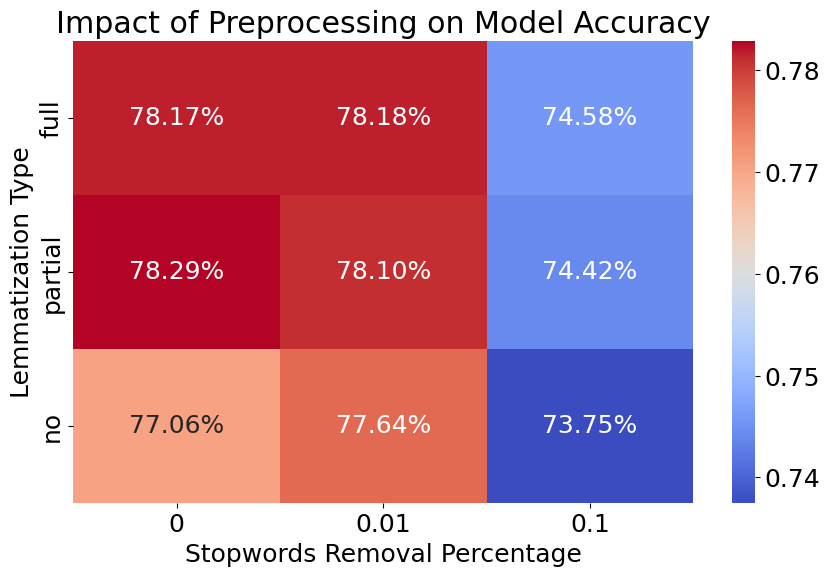

In [32]:
# Load data from JSON file
results_path = 'saved_results/results_stored.json'
with open(results_path, 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

# Glove Hyperparameters
embedding_dim = 800
alpha = 0.85
nmax = 5000
total_epochs = 3
learning_rate = 0.0001

# Logistic Regression Hyperparameters
lambda_ = 0.0
regularization_type = 'l2'

# Filter the DataFrame based on additional parameters
filtered_df = df[(df['embedding_dim'] == embedding_dim) & 
                 (df['alpha'] == alpha) &
                 (df['learning_rate'] == learning_rate) &
                 (df['total_epochs'] == total_epochs) &
                 (df['nmax'] == nmax) &
                 (df['lambda'] == lambda_) &
                 (df['regularization_type'] == regularization_type)].copy()  # Replace 'other_param' and 'value' as needed

# Rename and map columns to match the DataFrame's expected structure
filtered_df.rename(columns={
    'lemmatization_type': 'Lemmatization',
    'stopwords_threshold': 'Stopwords removal',
    'accuracy': 'Accuracy'
}, inplace=True)

# Map lemmatization types to more friendly names and convert to Categorical type
lem_order = ['full', 'partial', 'no']
filtered_df['Lemmatization'] = filtered_df['Lemmatization'].map({
    'no_lem': 'no',
    'half_lem': 'partial',
    'full_lem': 'full'
}).astype(pd.CategoricalDtype(categories=lem_order, ordered=True))

# Convert stopwords removal values to string
filtered_df['Stopwords removal'] = filtered_df['Stopwords removal'].astype(str)

# Create pivot table for visualization
pivot_df = filtered_df.pivot(
    index='Lemmatization', 
    columns='Stopwords removal', 
    values='Accuracy'
)

# Set the global font size
plt.rcParams.update({'font.size': 18})

# Plotting the heatmap
def plot_heatmap(pivot_df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2%")
    plt.title(title)
    plt.ylabel('Lemmatization Type')
    plt.xlabel('Stopwords Removal Percentage')
    plt.show()

# Plot heatmap
plot_heatmap(pivot_df, "Impact of Preprocessing on Model Accuracy")


### Hyperparameter search 2: GloVe embeddings training

In [23]:
results_path = 'saved_results/results_stored.json'

# Preprocessing Hyperparameters
lemmatization_types = ["half_lem"] # "no_lem" for no lemmatizaiton, "half_lem" for partial lemmatization and "full_lem" for complete lemmatization
stopwords_thresholds = [0] # in percentage

# Glove Hyperparameters
embedding_dims = [1000, 2000]
alphas = [0.5, 0.85]
nmaxs = [5000, 10000]
total_epochss = [3, 5]
learning_rates = [0.0001]

# Logistic Regression Hyperparameters
lambdas = [0.0]
regularization_types = ['l2']

dfs = {
    'df_no_lem': df_no_lem_red,
    'df_half_lem': df_half_lem_red,
    'df_full_lem': df_full_lem_red
    }

results = perform_experiments(lemmatization_types, stopwords_thresholds, embedding_dims, alphas, nmaxs, total_epochss, learning_rates, lambdas, regularization_types, dfs, results_path, cv=False)

/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [33]:
# Load data from JSON file
results_path = 'saved_results/results_stored.json'
with open(results_path, 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

df.head()

df_sorted = df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)
df_sorted.head(10)

,lemmatization_type,stopwords_threshold,embedding_dim,alpha,learning_rate,total_epochs,nmax,lambda,regularization_type,accuracy
0,half_lem,no_remove,2000,0.85,0.00010,3,5000,0,l2,0.790166
1,half_lem,no_remove,2000,0.85,0.00010,7,5000,0,l2,0.789614
2,half_lem,no_remove,2000,0.75,0.00010,3,5000,0,l2,0.789201
3,half_lem,no_remove,2000,0.85,0.00005,5,6000,0,l2,0.789173
4,half_lem,no_remove,2000,0.85,0.00010,5,6000,0,l2,0.788897
5,half_lem,no_remove,2000,0.85,0.00005,3,6000,0,l2,0.788649
6,half_lem,no_remove,2000,0.85,0.00010,3,7000,0,l2,0.788567
7,half_lem,no_remove,2000,0.85,0.00005,3,4000,0,l2,0.788484
8,half_lem,no_remove,2000,0.85,0.00005,5,4000,0,l2,0.788153
9,half_lem,no_remove,2000,0.85,0.00001,5,5000,0,l2,0.787932


In [23]:
import json
import pandas as pd

# Load the existing JSON data
existing_json_path = 'new_data.json'  # Replace with your existing file path
with open(existing_json_path, 'r') as file:
    existing_data = json.load(file)

# Load the new JSON data
new_json_path = 'old_data.json'  # Replace with your new file path
with open(new_json_path, 'r') as file:
    new_data = json.load(file)

# Transform the new data
for item in new_data:
    transformed_item = {
        'lemmatization_type': item['lem'],
        'stopwords_threshold': 0 if item['removal'] == 'no_remove' else float(item['removal'].split('_')[0]),
        'embedding_dim': 800,
        'alpha': 0.85,
        'learning_rate': 0.0001,
        'total_epochs': 3,
        'nmax': 5000,
        'lambda': 0,
        'regularization_type': 'l2',
        'accuracy': item['accuracy']
    }
    existing_data.append(transformed_item)

# Save the combined data back to JSON
output_path = 'combined_results.json'  # Choose your desired output file name
with open(output_path, 'w') as file:
    json.dump(existing_data, file, indent=4)

### Hyperparameter search 3: Logistic Regression

In [28]:
# Preprocessing Hyperparameters
lemmatization_types = ["half_lem"] # "no_lem" for no lemmatizaiton, "half_lem" for partial lemmatization and "full_lem" for complete lemmatization
stopwords_thresholds = [0] # in percentage

# Glove Hyperparameters
embedding_dims = [2000]
alphas = [0.85]
nmaxs = [10000]
total_epochss = [5]
learning_rates = [0.0001]

# Logistic Regression Hyperparameters
regularization_types = ['l2']
lambdas = [1e-1, 1, 10, 100, 1000]

results = perform_experiments(lemmatization_types, stopwords_thresholds, embedding_dims, alphas, nmaxs, total_epochss, learning_rates, lambdas, regularization_types, dfs, results_path, cv=True)

/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hanygeor/anaconda3/envs/hello/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

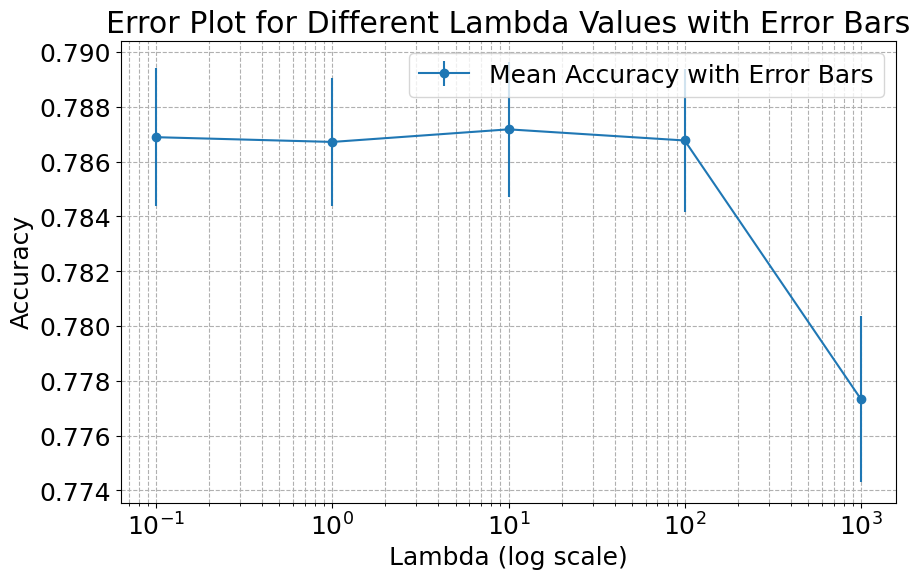

In [29]:
def plot_error_for_lambdas(results_list, lambdas):
    means = []
    stds = []

    for lambda_ in lambdas:
        accuracies = [r['cv_accuracy'] for r in results_list if r['lambda'] == lambda_ and 'cv_accuracy' in r]
        std_devs = [r['cv_std'] for r in results_list if r['lambda'] == lambda_ and 'cv_std' in r]

        if accuracies:
            means.append(np.mean(accuracies))
            stds.append(np.mean(std_devs))

    plt.figure(figsize=(10, 6))
    plt.errorbar(lambdas, means, yerr=stds, fmt='-o', label='Mean Accuracy with Error Bars')
    plt.xscale('log')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Error Plot for Different Lambda Values with Error Bars')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# Example usage:
plot_error_for_lambdas(results, lambdas)


## Training the final model

In [ ]:
# Optimal Hyperparameters

# Preprocessing Hyperparameters
lemmatization_type = "half_lem" # "no_lem" for no lemmatizaiton, "half_lem" for partial lemmatization and "full_lem" for complete lemmatization
stopwords_threshold = 0 # in percentage

# Glove Hyperparameters
embedding_dim = 2000
alpha = 0.85
nmax = 5000
total_epochs = 3
learning_rate = 0.0001

# Logistic Regression Hyperparameters
lambda_ = 100
regularization_type = 'l2'

In [ ]:
dfs = {
    'df_no_lem': df_no_lem_red,
    'df_half_lem': df_half_lem_red,
    'df_full_lem': df_full_lem_red
    }

results_path = 'saved_results/final_result.json'

In [ ]:
results = perform_experiments([lemmatization_type], [stopwords_threshold], [embedding_dim], [alpha], [nmax], [total_epochs], [learning_rate], [lambda_], [regularization_type], dfs, results_path, cv=False)

In [ ]:
with open('twitter-datasets/test_data.txt', 'r') as file:
    test_lines = file.readlines()

df_test = pd.DataFrame({'Text': test_lines})
df_test['Label'] = 0

In [ ]:
df_file_path = f'encoded_dfs/encoded_{lemmatization_type}_{stopwords_threshold}_{embedding_dim}_{alpha}_{learning_rate}_{nmax}.pkl'

if not os.path.exists(df_file_path):
    df_name = f'df_{lemmatization_type}'
    current_df = dfs.get(df_name, None)
    cooc_path = f'cooc_files/cooc_{df_name}_{stopwords_threshold}_remove.pkl'
    vocab_path = f'vocab_cut_files/vocab_cut_{df_name}_{stopwords_threshold}_remove.txt'

    xs = train_embeddings(embedding_dim, alpha, learning_rate, total_epochs, nmax, cooc_path)
    df = get_encoded_tweets(xs, vocab_path, df=current_df)
    save_df_to_file(df, df_file_path)
else:
    df = load_df_from_file(df_file_path)
    if df is None:
        raise Exception(f"Encoded dataframe for {df_name} not found")
    


X_train = df.drop(['Label', 'Text'], axis=1)
Y_train = df['Label']

X_test = get_encoded_tweets(xs, vocab_path, df=df_test, skip_nan=False).drop(['Label', 'Text'], axis=1)

if lambda_ == 0:
    classifier = LogisticRegression()
else:
    classifier = LogisticRegression(C=1/lambda_)

classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)